# IACV Exercise 5: Transfer Learning

In this exercise, you will again tackle the image classification task, as in exercise 4.
Given an input RGB image with resolution `(32, 32, 3)`, you need to predict which of the 10 input classes it belongs to.
However, unlike in exercise 4, you have access to limited training data in `training.h5`.
In fact, you only have `210` samples per class, which are separated into training, validation, and test sets of ratio `7:1:2` for ease of use.
You can use these three sets of data for your development.

Fortunately, you have access to a pre-trained network which has been trained on large amounts of data to classify 5 out of 10 input classes.
That is, the pre-trained network obtains a classification accuracy of around 95% for 5 of the classes, while the remaining classes are not defined at all.
The pretrained parameters are stored in `ckpt/resnet4five.pt` and the loading process explained below.

Your task is to either adapt this model, or train a new network from scratch which can classify all 10 classes.
Similar to exercise 4, we will use the [PyTorch](https://https://pytorch.org/) deep learning framework in this exercise.

**Evaluation Criteria**

Your algorithm will be evaluated using classification accuracy, which is the proportion of images with the correct predicted label.
The final EvaluationScore is obtained as the classification accuracy over all test samples, over all 10 classes.
The real test data used for evaluation has 1000 images without labels and can be found in `test.h5`

**Rules**

Throughout this project, you are **not allowed to use any other dataset and/or pre-trained model other than the given ones**.
You are allowed to use any other techniques you have learned in the course, including but not limited to
*data augmentation, early stopping, and transfer learning*.

In [1]:
# These two lines ensure that we always import the latest version of a package
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt


import os
import sys
import shutil
from pathlib import Path

import torch
import numpy as np


In [8]:
iacv_path = '/Users/joelflueckiger/Desktop/IACV/5/'

env_path = iacv_path
# Add the handout folder to python paths
if env_path not in sys.path:
    sys.path.append(str(env_path))

## Enabeling GPU on CoLab
For this exercise you might want to use a GPU.
Even the small ResNet we provide runs more than 25 times faster on CoLabs free GPU compared to CoLabs CPUs.

In the CoLab menu, go to `Runtime` -> `Change Runtime Type` and select `T4 GPU` as harware accelerator.

Note that this is free! You will not need to pay anything to use this service!

In [3]:
# With PyTorch you can check if a GPU is available as follows:
print(f"Is a CUDA capable GPU available? {torch.cuda.is_available()}")

# Note: CUDA is the platform developed by NVIDIA for their GPUs

Is a CUDA capable GPU available? False


## Mapping from 5 to 10 classes

Define a mapping from 5 to 10 classes because the indices do not match, such as `classes[0]` is `Airplane` while `classes5[0]` is `Cat`

In [9]:
# Mapping from 5 to 10 classes

# Classes for the pretrained dataset
classes5 = ["Cat", "Deer", "Frog", "Ship", "Truck"]

# Actual classes
classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
           "Dog", "Frog", "Horse", "Ship", "Truck"]

# Converting numpy arrays for indexing
classes5 = np.array(classes5)
classes = np.array(classes)

# Mapping from 5 classes to 10 classes for evaluation
map5to10 = [np.where(classes==class_)[0][0] for class_ in classes5]
map5to10 = np.array(map5to10)
print("Mapping array is:", map5to10)

Mapping array is: [3 4 6 8 9]


In [10]:
# Example usage

# Random predictions by 5
preds5 = np.random.randint(5, size=7, dtype=int)

# Predicted classes
print("Actual Predictions:        ", classes5[preds5])

# Wrong mapping from 5 to 10 classes
print("Wrongly-mapped Predictions:", classes[preds5])

# Correct mapping from 5 to 10 classes
print("Correct-mapped Predictions:", classes[map5to10[preds5]])

Actual Predictions:         ['Cat' 'Truck' 'Deer' 'Cat' 'Truck' 'Frog' 'Ship']
Wrongly-mapped Predictions: ['Airplane' 'Deer' 'Automobile' 'Airplane' 'Deer' 'Bird' 'Cat']
Correct-mapped Predictions: ['Cat' 'Truck' 'Deer' 'Cat' 'Truck' 'Frog' 'Ship']


## Create dataloaders

We have implemented the basic data handling.
You might want to check out the file `dataset.py` nonetheless.
In case you want to apply data augmentations during training, etc...


In [11]:
from dataset import get_datasets_from_h5, get_loaders_from_datasets
import os

# Get the datasets
data_path = os.path.join(env_path, 'data')
train_dataset, val_dataset, test_dataset = get_datasets_from_h5(os.path.join(data_path, 'training.h5'))

# Construct the dataloaders
batch_size = 24
train_loader, val_loader, test_loader = get_loaders_from_datasets(
    train_dataset, val_dataset, test_dataset, batch_size
)

# Print the sizes of the datasets
print(f"The dataset contains {train_dataset.num_classes} classes.")
print(f"Number of images in each dataset: Training={len(train_dataset)}, ",
      f"Validation={len(val_dataset)}, Test={len(test_dataset)}")


The dataset contains 10 classes.
Number of images in each dataset: Training=1470,  Validation=210, Test=420


## Visualize training images

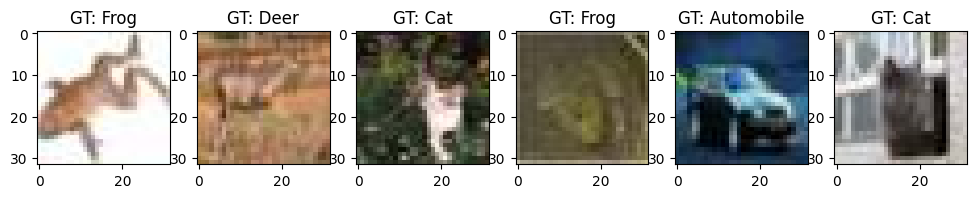

In [12]:
from utils import show_images

dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images(images[:6], classes[labels[:6]])

## Load pre-trained model

As mentioned before, you have access to parameters of a pre-trained model `resnet4five.pt`, which is a standard ResNet18 model and has been trained to classify images into 5 classes ("Cat", "Deer", "Frog", "Ship", "Truck"), using larger dataset. It achieves accuracy of higher than 90% for these classes.

In [18]:
from model import generate_resnet

# Path to load the model from
load_path = os.path.join(env_path, 'ckpt/resnet4five.pt')

# Device to train on
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the model with 5 output classes
model = generate_resnet(num_classes=5)

# Next we load the pre-trained weights, and set it to the model we created
model.load_state_dict(torch.load(load_path, map_location=device, weights_only=True))

<All keys matched successfully>

Next, we can test the pre-trained model on the dataset.
Check out the file `evaluation.py` to see how the model is used to make a prediction.
A very similar code will be used to create your prediction at the end of this file.

Test accuracy with pretrained model: 0.476


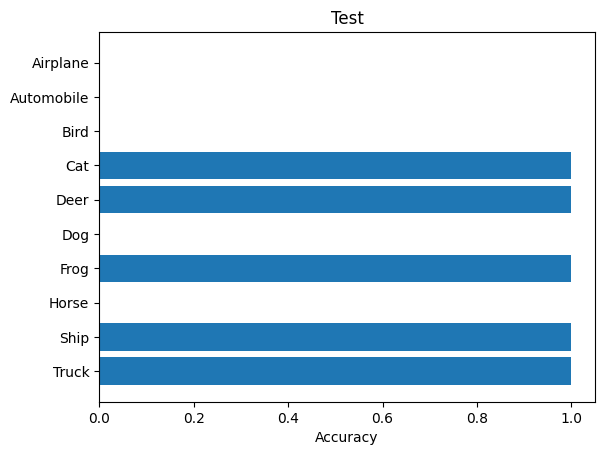

In [19]:
from evaluation import evaluate_model
from utils import show_class_accs

# Evaluate the model
test_accuracy = evaluate_model(model, test_loader, device=device, mapping=map5to10)
print(f"Test accuracy with pretrained model: {test_accuracy:.3f}")

# Classwise accuracies
test_class_accs = evaluate_model(
    model, test_loader, device=device, mapping=map5to10, classwise=True
)

show_class_accs(test_class_accs, classes, title="Test")

As expected, we see the the pre-trained model obtains good performance on the 5 out of 10 classes which it has been trained for. However, it cannot handle the other 5 *unseen* classes, and thus obtains a low overall classification accuracy. Your task is to adapt this pre-trained model such that it obtains better overall classification accuracy than iacvbasline.

## Your Solution

You can write your own implementation here.
You can change the custom functions given according to your needs.

In [21]:
# For convenience reimport all custom functions
from utils import seed_everything
from model import generate_resnet
from dataset import get_datasets_from_h5, get_loaders_from_datasets
from training import train_model, plot_training_log
from evaluation import evaluate_model

from torchsummary import summary

 # Give your Legi number as random seed
seed = 15941073
seed_everything(seed)

#
# Write your implementation here
# You can also implement the training loop in the file `training.py`
#

ImportError: cannot import name 'plot_training_log' from 'training' (/Users/joelflueckiger/Desktop/IACV/5/training.py)

## Generating the final submission

When you are happy with your network, you can run the next cell to generate your network predictions on the test set, which will be stored in the submission directory on your Google Drive.
Download the submission folder (without renaming) as a zip, and upload it to the evaluation server to obtain the scores on the test set.

In [ ]:
from dataset import get_test_loader

test_h5_path = env_path / 'data' / 'test.h5'

submission_path = env_path / 'submission'
submission_path.mkdir(exist_ok=True)

# Choose device to run inference
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load test dataset and dataloader
test_loader = get_test_loader(test_h5_path)

# Predictions to store
predictions = list()

# Set to evaluation mode
model.eval()

# Iterate over the test set
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Get the predictions
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        predictions.extend(preds.tolist())

# Save the outputs (do not change the name)
np.savetxt(submission_path / 'labels.csv', predictions, fmt="%d")

# Save the relevant files (do not change the name)
shutil.copyfile(env_path / 'model.py', submission_path / 'model.py')
shutil.copyfile(env_path / 'dataset.py', submission_path / 'dataset.py')
shutil.copyfile(env_path / 'training.py', submission_path / 'training.py')
shutil.copyfile(env_path / 'handout.ipynb', submission_path / 'handout.ipynb')

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# # Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    batch_size = trial.suggest_int('batch_size', 4, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.9)
    num_epochs = trial.suggest_int('num_epochs', 1, 10)

    # Get transforms
    transform_train = get_transforms_train()
    transform_val = get_transforms_val()

    # Generate our data loaders
    dataset_train = ImageDataset(os.path.join(data_path, 'train.csv'), os.path.join(data_path, 'train.hdf5'), get_transforms_train())
    dataset_valid = ImageDataset(os.path.join(data_path, 'train.csv'), os.path.join(data_path, 'train.hdf5'), get_transforms_val())

    train_loader = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=0)
    valid_loader = DataLoader(dataset_valid, batch_size, shuffle=True, num_workers=0)

    # create CNN model
    model = CNN()

    # Get optimizer and loss functions
    criterion = get_loss_function()
    optimizer = get_optimizer(cnn_network, lr=learning_rate, momentum=momentum)
    
    # Initialize model, loss function, and optimizer
    #model = SimpleModel()
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Training loop
    for epoch in range(num_epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Return the final loss
    return loss.item()

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print best hyperparameters
print(study.best_params)

[I 2024-11-29 00:15:03,401] A new study created in memory with name: no-name-58ce5075-0710-4655-a78b-b32201352998
/var/folders/69/wyx1_l6s2j75y6x1rp51xhnw0000gn/T/ipykernel_56636/3256389479.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/folders/69/wyx1_l6s2j75y6x1rp51xhnw0000gn/T/ipykernel_56636/3256389479.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.5, 0.9)
[I 2024-11-29 00:15:19,443] Trial 0 finished with value: 1.339611530303955 and parameters: {'batch_size': 49, 'learning_rate': 0.003396027167994248, 'momentum': 0.5536529907642235, 'num_epochs': 8}. Best is trial 0 with value: 1.339611530303955.
[I 2024-11-29 00:15:33,314] Trial 1 finished with value: 1.1682674884796143 and parameters: {'batch_size': 7, 'learning_rate': 9.866454358555316e-05, 'momentum': 0.6839706070772126, 'num_epochs': 7}. Best is trial 1 with value: 1.1682674884796143.
[I 2024-11-29 00:15:43,061] Trial 2 finished with value: 0.8067861199378967 and parameters: {'batch_size': 53, 'learning_rate': 0.009024766367182543, 'momentum': 0.6536916478394587, 'num_epochs': 5}. Best is trial 2 with value: 0.8067861199378967.
[I 2024-11-29 00:15:46,993] Trial 3 finished with value: 1.735515832901001 and parameters: {'batch_size': 59, 'learning_rate': 0.00013274730303887303, 'momentum': 0.6420475713151902, 'num_epochs': 2}. Best is trial 2 with value: 0.8067861199378967.
[I 2024-11-29 00:15:58,741] Trial 4 finished with value: 0.9261866211891174 and parameters: {'batch_size': 43, 'learning_rate': 0.06601051306013475, 'momentum': 0.5957736098901155, 'num_epochs': 6}. Best is trial 2 with value: 0.8067861199378967.
[I 2024-11-29 00:16:15,165] Trial 5 finished with value: 1.540173053741455 and parameters: {'batch_size': 12, 'learning_rate': 0.0041651214701169, 'momentum': 0.7954219307246003, 'num_epochs': 9}. Best is trial 2 with value: 0.8067861199378967.
[I 2024-11-29 00:16:33,520] Trial 6 finished with value: 0.6685448884963989 and parameters: {'batch_size': 11, 'learning_rate': 0.010951712010580875, 'momentum': 0.6307000653648344, 'num_epochs': 10}. Best is trial 6 with value: 0.6685448884963989.
[I 2024-11-29 00:16:46,984] Trial 7 finished with value: 0.7454557418823242 and parameters: {'batch_size': 54, 'learning_rate': 0.08561848323341668, 'momentum': 0.5903667806399371, 'num_epochs': 7}. Best is trial 6 with value: 0.6685448884963989.
[I 2024-11-29 00:16:49,046] Trial 8 finished with value: 1.0272589921951294 and parameters: {'batch_size': 34, 'learning_rate': 0.014373932585103472, 'momentum': 0.8755666118388061, 'num_epochs': 1}. Best is trial 6 with value: 0.6685448884963989.
[I 2024-11-29 00:16:58,742] Trial 9 finished with value: 1.8060474395751953 and parameters: {'batch_size': 61, 'learning_rate': 1.1328210354085518e-05, 'momentum': 0.7416827076810573, 'num_epochs': 5}. Best is trial 6 with value: 0.6685448884963989.
[I 2024-11-29 00:17:19,479] Trial 10 finished with value: 0.8995790481567383 and parameters: {'batch_size': 22, 'learning_rate': 0.0011490712404270617, 'momentum': 0.7583872162408523, 'num_epochs': 10}. Best is trial 6 with value: 0.6685448884963989.
[I 2024-11-29 00:17:39,709] Trial 11 finished with value: 0.996199905872345 and parameters: {'batch_size': 30, 'learning_rate': 0.09186968815364732, 'momentum': 0.5378185506167475, 'num_epochs': 10}. Best is trial 6 with value: 0.6685448884963989.
[I 2024-11-29 00:17:46,114] Trial 12 finished with value: 1.0437862873077393 and parameters: {'batch_size': 18, 'learning_rate': 0.02216213513993576, 'momentum': 0.504497851333874, 'num_epochs': 3}. Best is trial 6 with value: 0.6685448884963989.
[I 2024-11-29 00:18:02,174] Trial 13 finished with value: 0.4715855121612549 and parameters: {'batch_size': 43, 'learning_rate': 0.03569847722754016, 'momentum': 0.6037562142349596, 'num_epochs': 8}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:18:20,136] Trial 14 finished with value: 1.1232578754425049 and parameters: {'batch_size': 41, 'learning_rate': 0.0015874991817121317, 'momentum': 0.608672496971335, 'num_epochs': 9}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:18:36,270] Trial 15 finished with value: 0.6250123977661133 and parameters: {'batch_size': 29, 'learning_rate': 0.02599545452740926, 'momentum': 0.6951607025716249, 'num_epochs': 8}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:18:52,487] Trial 16 finished with value: 1.0451076030731201 and parameters: {'batch_size': 26, 'learning_rate': 0.00024041185816965751, 'momentum': 0.7030355053925439, 'num_epochs': 8}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:19:00,386] Trial 17 finished with value: 1.5048377513885498 and parameters: {'batch_size': 41, 'learning_rate': 0.03308648631652411, 'momentum': 0.8067413543566325, 'num_epochs': 4}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:19:14,308] Trial 18 finished with value: 1.285591959953308 and parameters: {'batch_size': 36, 'learning_rate': 0.0003986884317115397, 'momentum': 0.7034367253894704, 'num_epochs': 7}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:19:29,908] Trial 19 finished with value: 1.0564006567001343 and parameters: {'batch_size': 47, 'learning_rate': 0.005018611828901115, 'momentum': 0.6749454612743745, 'num_epochs': 8}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:19:42,082] Trial 20 finished with value: 1.4795669317245483 and parameters: {'batch_size': 26, 'learning_rate': 0.037628490606557305, 'momentum': 0.897355513463965, 'num_epochs': 6}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:19:56,629] Trial 21 finished with value: 1.378395676612854 and parameters: {'batch_size': 14, 'learning_rate': 0.010433131815047604, 'momentum': 0.6322622267004055, 'num_epochs': 9}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:20:16,246] Trial 22 finished with value: 0.5599036812782288 and parameters: {'batch_size': 6, 'learning_rate': 0.03151943602446725, 'momentum': 0.5695579596763993, 'num_epochs': 10}. Best is trial 13 with value: 0.4715855121612549.
[I 2024-11-29 00:20:34,241] Trial 23 finished with value: 0.24325020611286163 and parameters: {'batch_size': 37, 'learning_rate': 0.03543611440416277, 'momentum': 0.5604782071351722, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:20:51,941] Trial 24 finished with value: 0.7536502480506897 and parameters: {'batch_size': 40, 'learning_rate': 0.046842630105021314, 'momentum': 0.5613943502034876, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:21:11,889] Trial 25 finished with value: 1.1115314960479736 and parameters: {'batch_size': 35, 'learning_rate': 0.0023656734919871945, 'momentum': 0.50686449153467, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:21:29,786] Trial 26 finished with value: 1.1652075052261353 and parameters: {'batch_size': 5, 'learning_rate': 0.006395626799142613, 'momentum': 0.5738173831761938, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:21:49,291] Trial 27 finished with value: 0.6303253173828125 and parameters: {'batch_size': 48, 'learning_rate': 0.019789633115781153, 'momentum': 0.5443776698247017, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:22:04,068] Trial 28 finished with value: 1.7032369375228882 and parameters: {'batch_size': 20, 'learning_rate': 1.7544700573296654e-05, 'momentum': 0.6159140549433592, 'num_epochs': 7}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:22:19,686] Trial 29 finished with value: 1.2036466598510742 and parameters: {'batch_size': 53, 'learning_rate': 0.0005830014851720978, 'momentum': 0.5314839379209307, 'num_epochs': 8}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:22:36,286] Trial 30 finished with value: 0.9742217659950256 and parameters: {'batch_size': 45, 'learning_rate': 0.00306800375807984, 'momentum': 0.5743016665940286, 'num_epochs': 8}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:22:53,013] Trial 31 finished with value: 1.1134347915649414 and parameters: {'batch_size': 31, 'learning_rate': 0.026685139237499964, 'momentum': 0.73742540044925, 'num_epochs': 8}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:23:13,749] Trial 32 finished with value: 0.4030461311340332 and parameters: {'batch_size': 27, 'learning_rate': 0.04894796257584829, 'momentum': 0.6669033968651521, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:23:32,675] Trial 33 finished with value: 0.5152674317359924 and parameters: {'batch_size': 38, 'learning_rate': 0.052057921145169175, 'momentum': 0.6614857669908167, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:23:50,950] Trial 34 finished with value: 0.799102246761322 and parameters: {'batch_size': 39, 'learning_rate': 0.05340692586760387, 'momentum': 0.6609140931498595, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:24:03,881] Trial 35 finished with value: 1.2653417587280273 and parameters: {'batch_size': 37, 'learning_rate': 0.09924805021013042, 'momentum': 0.6740066523916451, 'num_epochs': 6}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:24:22,188] Trial 36 finished with value: 0.8725043535232544 and parameters: {'batch_size': 33, 'learning_rate': 0.013785324571582965, 'momentum': 0.6456889663869199, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:24:36,625] Trial 37 finished with value: 0.9776862263679504 and parameters: {'batch_size': 24, 'learning_rate': 0.054725385873179634, 'momentum': 0.6231637981055477, 'num_epochs': 7}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:24:54,949] Trial 38 finished with value: 1.6677383184432983 and parameters: {'batch_size': 51, 'learning_rate': 5.167838451475243e-05, 'momentum': 0.5933437208931291, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:25:09,298] Trial 39 finished with value: 1.1543809175491333 and parameters: {'batch_size': 43, 'learning_rate': 0.00799832833632235, 'momentum': 0.7186239661826873, 'num_epochs': 7}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:25:19,094] Trial 40 finished with value: 0.7729465365409851 and parameters: {'batch_size': 64, 'learning_rate': 0.01576069195731111, 'momentum': 0.6573302941557116, 'num_epochs': 5}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:25:37,555] Trial 41 finished with value: 0.5222169756889343 and parameters: {'batch_size': 10, 'learning_rate': 0.04497182065173974, 'momentum': 0.5978332032172565, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:25:56,228] Trial 42 finished with value: 1.6439874172210693 and parameters: {'batch_size': 10, 'learning_rate': 0.06367104181341443, 'momentum': 0.59876990005249, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:26:12,301] Trial 43 finished with value: 1.0869228839874268 and parameters: {'batch_size': 15, 'learning_rate': 0.04784588675308821, 'momentum': 0.6371099209132812, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:26:29,719] Trial 44 finished with value: 1.4572762250900269 and parameters: {'batch_size': 56, 'learning_rate': 0.07216325420660388, 'momentum': 0.5259956519354034, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:26:45,425] Trial 45 finished with value: 0.6425115466117859 and parameters: {'batch_size': 44, 'learning_rate': 0.016605840867211796, 'momentum': 0.5811200243166816, 'num_epochs': 8}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:27:05,483] Trial 46 finished with value: 0.9764099717140198 and parameters: {'batch_size': 32, 'learning_rate': 0.0383465646581592, 'momentum': 0.6153917325450996, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:27:23,634] Trial 47 finished with value: 0.5224770903587341 and parameters: {'batch_size': 28, 'learning_rate': 0.09844251105673872, 'momentum': 0.5539234999579091, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:27:25,635] Trial 48 finished with value: 1.1686434745788574 and parameters: {'batch_size': 38, 'learning_rate': 0.010613484868151559, 'momentum': 0.6007188631668315, 'num_epochs': 1}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:27:29,323] Trial 49 finished with value: 1.2727611064910889 and parameters: {'batch_size': 8, 'learning_rate': 0.022782230598661843, 'momentum': 0.6587169202452824, 'num_epochs': 2}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:27:37,860] Trial 50 finished with value: 0.45034345984458923 and parameters: {'batch_size': 18, 'learning_rate': 0.03664849759578176, 'momentum': 0.6809847077466676, 'num_epochs': 4}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:27:46,193] Trial 51 finished with value: 0.820681095123291 and parameters: {'batch_size': 20, 'learning_rate': 0.07010236954051163, 'momentum': 0.6875397063011586, 'num_epochs': 4}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:27:54,850] Trial 52 finished with value: 0.9312850832939148 and parameters: {'batch_size': 17, 'learning_rate': 0.0340179260829382, 'momentum': 0.7725399269065447, 'num_epochs': 4}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:28:00,275] Trial 53 finished with value: 1.0304365158081055 and parameters: {'batch_size': 13, 'learning_rate': 0.021730173604484124, 'momentum': 0.6733417290176295, 'num_epochs': 3}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:28:16,736] Trial 54 finished with value: 1.1483811140060425 and parameters: {'batch_size': 9, 'learning_rate': 0.04111678730571549, 'momentum': 0.7337112282318341, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:28:23,030] Trial 55 finished with value: 0.9497520923614502 and parameters: {'batch_size': 25, 'learning_rate': 0.06459454007171075, 'momentum': 0.6271141601652873, 'num_epochs': 3}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:28:34,962] Trial 56 finished with value: 1.3820369243621826 and parameters: {'batch_size': 35, 'learning_rate': 0.006068929935297295, 'momentum': 0.703129508399762, 'num_epochs': 6}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:28:45,512] Trial 57 finished with value: 0.7054494023323059 and parameters: {'batch_size': 22, 'learning_rate': 0.01222381717691239, 'momentum': 0.6447821667546838, 'num_epochs': 5}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:29:05,230] Trial 58 finished with value: 1.0548903942108154 and parameters: {'batch_size': 46, 'learning_rate': 0.02901777952281231, 'momentum': 0.6865136959294265, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:29:24,789] Trial 59 finished with value: 0.9069115519523621 and parameters: {'batch_size': 42, 'learning_rate': 0.0077923638076882245, 'momentum': 0.5900322344276034, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:29:41,978] Trial 60 finished with value: 1.2917530536651611 and parameters: {'batch_size': 17, 'learning_rate': 0.017850922655358658, 'momentum': 0.516911586852258, 'num_epochs': 8}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:30:00,201] Trial 61 finished with value: 0.9002308249473572 and parameters: {'batch_size': 28, 'learning_rate': 0.0917882608561403, 'momentum': 0.5532764083718344, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:30:16,324] Trial 62 finished with value: 1.078161358833313 and parameters: {'batch_size': 28, 'learning_rate': 0.04340706544087801, 'momentum': 0.5462151635796946, 'num_epochs': 8}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:30:34,375] Trial 63 finished with value: 0.9014462828636169 and parameters: {'batch_size': 30, 'learning_rate': 0.09737089132562753, 'momentum': 0.5571113326024959, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:30:55,303] Trial 64 finished with value: 0.5269923806190491 and parameters: {'batch_size': 4, 'learning_rate': 0.029128023503876936, 'momentum': 0.5834180882589783, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:31:13,900] Trial 65 finished with value: 0.8391786813735962 and parameters: {'batch_size': 23, 'learning_rate': 0.07124843192829505, 'momentum': 0.6048913235370627, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:31:30,034] Trial 66 finished with value: 0.8799925446510315 and parameters: {'batch_size': 34, 'learning_rate': 0.047599080816479324, 'momentum': 0.5620083970227339, 'num_epochs': 8}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:31:48,561] Trial 67 finished with value: 2.6919105052948 and parameters: {'batch_size': 27, 'learning_rate': 0.05808199861884996, 'momentum': 0.8324180230376788, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:32:09,366] Trial 68 finished with value: 0.5858989953994751 and parameters: {'batch_size': 50, 'learning_rate': 0.02612519991566275, 'momentum': 0.7138217743268206, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:32:17,328] Trial 69 finished with value: 1.767022967338562 and parameters: {'batch_size': 38, 'learning_rate': 0.00010149528922769379, 'momentum': 0.673757454815594, 'num_epochs': 4}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:32:35,285] Trial 70 finished with value: 0.5639891028404236 and parameters: {'batch_size': 40, 'learning_rate': 0.036417060261379704, 'momentum': 0.6131190859255943, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:32:54,700] Trial 71 finished with value: 1.5502218008041382 and parameters: {'batch_size': 5, 'learning_rate': 0.027163553336165176, 'momentum': 0.5776830742356883, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[W 2024-11-29 00:33:15,927] Trial 72 failed with parameters: {'batch_size': 4, 'learning_rate': 0.07636161463175621, 'momentum': 0.5868899304183461, 'num_epochs': 10} because of the following error: The value nan is not acceptable.
[W 2024-11-29 00:33:15,928] Trial 72 failed with value nan.
[W 2024-11-29 00:33:35,013] Trial 73 failed with parameters: {'batch_size': 7, 'learning_rate': 0.0771331161286031, 'momentum': 0.58815285553579, 'num_epochs': 10} because of the following error: The value nan is not acceptable.
[W 2024-11-29 00:33:35,014] Trial 73 failed with value nan.
[I 2024-11-29 00:33:53,418] Trial 74 finished with value: 1.087013602256775 and parameters: {'batch_size': 12, 'learning_rate': 0.07469793775319371, 'momentum': 0.5901119030676455, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[W 2024-11-29 00:34:14,648] Trial 75 failed with parameters: {'batch_size': 4, 'learning_rate': 0.052610259156462696, 'momentum': 0.5343126556198621, 'num_epochs': 10} because of the following error: The value nan is not acceptable.
[W 2024-11-29 00:34:14,649] Trial 75 failed with value nan.
[I 2024-11-29 00:34:35,550] Trial 76 finished with value: 0.7610269784927368 and parameters: {'batch_size': 20, 'learning_rate': 0.019792393715256346, 'momentum': 0.5369266650283836, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:34:49,882] Trial 77 finished with value: 0.9781895279884338 and parameters: {'batch_size': 15, 'learning_rate': 0.04845546617356404, 'momentum': 0.5689270619898887, 'num_epochs': 9}. Best is trial 23 with value: 0.24325020611286163.
[I 2024-11-29 00:35:08,214] Trial 78 finished with value: 1.3998044729232788 and parameters: {'batch_size': 8, 'learning_rate': 0.03284021639404953, 'momentum': 0.523453160826063, 'num_epochs': 10}. Best is trial 23 with value: 0.24325020611286163.
[W 2024-11-29 00:35:26,940] Trial 79 failed with parameters: {'batch_size': 4, 'learning_rate': 0.052806429309766666, 'momentum': 0.6496107115911096, 'num_epochs': 9} because of the following error: The value nan is not acceptable.
[W 2024-11-29 00:35:26,941] Trial 79 failed with value nan.
[I 2024-11-29 00:35:43,640] Trial 80 finished with value: 0.2103382796049118 and parameters: {'batch_size': 7, 'learning_rate': 0.0008181759892330201, 'momentum': 0.5836702155228951, 'num_epochs': 9}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:35:59,755] Trial 81 finished with value: 1.0193557739257812 and parameters: {'batch_size': 31, 'learning_rate': 0.0011240905075925048, 'momentum': 0.648140781777986, 'num_epochs': 8}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:36:12,756] Trial 82 finished with value: 0.8407614827156067 and parameters: {'batch_size': 11, 'learning_rate': 0.0017650320939777, 'momentum': 0.6251100010559152, 'num_epochs': 7}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:36:29,014] Trial 83 finished with value: 1.2690303325653076 and parameters: {'batch_size': 36, 'learning_rate': 0.00044613185151907503, 'momentum': 0.5518795273421877, 'num_epochs': 8}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:36:47,506] Trial 84 finished with value: 0.7249031066894531 and parameters: {'batch_size': 6, 'learning_rate': 0.00037103900057967805, 'momentum': 0.5006441990696262, 'num_epochs': 9}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:37:07,115] Trial 85 finished with value: 1.187123417854309 and parameters: {'batch_size': 4, 'learning_rate': 0.000616964058165222, 'momentum': 0.5874493684015913, 'num_epochs': 9}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:37:26,322] Trial 86 finished with value: 0.6079773306846619 and parameters: {'batch_size': 4, 'learning_rate': 0.0001947969141265353, 'momentum': 0.5633384102488028, 'num_epochs': 9}. Best is trial 80 with value: 0.2103382796049118.
[W 2024-11-29 00:37:45,578] Trial 87 failed with parameters: {'batch_size': 7, 'learning_rate': 0.079383375412047, 'momentum': 0.5831826679724411, 'num_epochs': 10} because of the following error: The value nan is not acceptable.
[W 2024-11-29 00:37:45,579] Trial 87 failed with value nan.
[I 2024-11-29 00:38:04,202] Trial 88 finished with value: 0.922138512134552 and parameters: {'batch_size': 10, 'learning_rate': 0.0015681110137025802, 'momentum': 0.5803619154181634, 'num_epochs': 10}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:38:23,679] Trial 89 finished with value: 0.6969326734542847 and parameters: {'batch_size': 7, 'learning_rate': 0.0008849418085007394, 'momentum': 0.6660543870783538, 'num_epochs': 10}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:38:41,957] Trial 90 finished with value: 1.1949957609176636 and parameters: {'batch_size': 33, 'learning_rate': 0.08358722091426414, 'momentum': 0.6074341387884307, 'num_epochs': 9}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:38:50,279] Trial 91 finished with value: 0.5412724018096924 and parameters: {'batch_size': 14, 'learning_rate': 0.003859848290070898, 'momentum': 0.5393223227214663, 'num_epochs': 5}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:38:54,329] Trial 92 finished with value: 0.9778334498405457 and parameters: {'batch_size': 41, 'learning_rate': 0.060281798697587013, 'momentum': 0.6348520616523237, 'num_epochs': 2}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:39:11,624] Trial 93 finished with value: 1.1365934610366821 and parameters: {'batch_size': 7, 'learning_rate': 0.01461312589527065, 'momentum': 0.6009078315250163, 'num_epochs': 9}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:39:29,171] Trial 94 finished with value: 0.5518882274627686 and parameters: {'batch_size': 18, 'learning_rate': 0.039466336691301694, 'momentum': 0.716778774720039, 'num_epochs': 8}. Best is trial 80 with value: 0.2103382796049118.
[I 2024-11-29 00:39:47,869] Trial 95 finished with value: 0.19054166972637177 and parameters: {'batch_size': 11, 'learning_rate': 0.02301828924424432, 'momentum': 0.6172064071001504, 'num_epochs': 10}. Best is trial 95 with value: 0.19054166972637177.
[I 2024-11-29 00:40:06,474] Trial 96 finished with value: 0.40289047360420227 and parameters: {'batch_size': 9, 'learning_rate': 0.024110429834501575, 'momentum': 0.6200028522626092, 'num_epochs': 10}. Best is trial 95 with value: 0.19054166972637177.
[I 2024-11-29 00:40:24,932] Trial 97 finished with value: 1.1397533416748047 and parameters: {'batch_size': 12, 'learning_rate': 0.04981154705108085, 'momentum': 0.6192082424214332, 'num_epochs': 10}. Best is trial 95 with value: 0.19054166972637177.
[I 2024-11-29 00:40:43,775] Trial 98 finished with value: 0.40891292691230774 and parameters: {'batch_size': 9, 'learning_rate': 0.021142945168910278, 'momentum': 0.6480402408651704, 'num_epochs': 10}. Best is trial 95 with value: 0.19054166972637177.
[I 2024-11-29 00:41:02,548] Trial 99 finished with value: 0.8001851439476013 and parameters: {'batch_size': 9, 'learning_rate': 0.017843630680175377, 'momentum': 0.6401117762064967, 'num_epochs': 10}. Best is trial 95 with value: 0.19054166972637177.
{'batch_size': 11, 'learning_rate': 0.02301828924424432, 'momentum': 0.6172064071001504, 'num_epochs': 10}
